Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Iport Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape of Dataset

In [3]:
dataset_path = "/content/drive/MyDrive/animals"
dirs = ['cats', 'dogs', 'panda']   # 3 classes
X, y = [], []
img_size = (64, 64)

for i, dir_name in enumerate(dirs):
    dir_path = os.path.join(dataset_path, dir_name)
    paths = sorted(os.listdir(dir_path))[:800]

    for file in paths:
        full_path = os.path.join(dir_path, file)
        try:
            img = cv2.imread(full_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                resized_img = cv2.resize(img, img_size)
                X.append(resized_img)
                y.append(i)
        except:
            pass

# Convert to numpy arrays
X = np.array(X) / 255.0   # normalize
Y = np.array(y).reshape(-1, 1)

# One-hot encode labels
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(Y)

# Flatten images for MLP
X = X.reshape(len(X), -1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (240, 12288)
y_train shape: (240, 3)


Neural network

In [4]:
class ImprovedNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim, lr=0.1):
        self.lr = lr
        self.W1 = np.random.randn(input_dim, hidden1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2.0 / hidden1)
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, hidden3) * np.sqrt(2.0 / hidden2)
        self.b3 = np.zeros((1, hidden3))
        self.W4 = np.random.randn(hidden3, output_dim) * np.sqrt(2.0 / hidden3)
        self.b4 = np.zeros((1, output_dim))

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1-x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = np.dot(self.h1, self.W2) + self.b2
        self.h2 = self.relu(self.z2)
        self.z3 = np.dot(self.h2, self.W3) + self.b3
        self.h3 = self.relu(self.z3)
        self.z4 = np.dot(self.h3, self.W4) + self.b4
        self.out = self.softmax(self.z4)
        return self.out

    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        dZ4 = pred - Y
        dW4 = np.dot(self.h3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m

        dH3 = np.dot(dZ4, self.W4.T) * self.relu(self.z3, der=True)
        dW3 = np.dot(self.h2.T, dH3) / m
        db3 = np.sum(dH3, axis=0, keepdims=True) / m

        dH2 = np.dot(dH3, self.W3.T) * self.relu(self.z2, der=True)
        dW2 = np.dot(self.h1.T, dH2) / m
        db2 = np.sum(dH2, axis=0, keepdims=True) / m

        dH1 = np.dot(dH2, self.W2.T) * self.relu(self.z1, der=True)
        dW1 = np.dot(X.T, dH1) / m
        db1 = np.sum(dH1, axis=0, keepdims=True) / m

        reg_lambda = 0.001
        self.W4 -= self.lr * (dW4 + reg_lambda * self.W4); self.b4 -= self.lr * db4
        self.W3 -= self.lr * (dW3 + reg_lambda * self.W3); self.b3 -= self.lr * db3
        self.W2 -= self.lr * (dW2 + reg_lambda * self.W2); self.b2 -= self.lr * db2
        self.W1 -= self.lr * (dW1 + reg_lambda * self.W1); self.b1 -= self.lr * db1

    def train(self, X, Y, epochs=5000):
        losses = []
        accuracies = []
        for i in range(epochs):
            pred = self.feedForward(X)

            # Cross entropy + L2 regularization
            reg_loss = 0.001 * (np.sum(self.W1**2) + np.sum(self.W2**2) +
                                np.sum(self.W3**2) + np.sum(self.W4**2)) / (2 * X.shape[0])
            loss = -np.mean(np.sum(Y * np.log(pred + 1e-8), axis=1)) + reg_loss
            losses.append(loss)

            # Accuracy
            train_pred = np.argmax(pred, axis=1)
            train_true = np.argmax(Y, axis=1)
            acc = np.mean(train_pred == train_true)
            accuracies.append(acc)

            # Backpropagation
            self.backPropagation(X, Y, pred)

            # Print every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            # Decay learning rate every 200 epochs
            if i > 0 and i % 200 == 0:
                self.lr *= 0.5
                print(f"Reduced learning rate to {self.lr}")

        return losses, accuracies

    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)


Train Model

In [5]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train.shape[0]}")

# Now requires hidden1, hidden2, hidden3
nn = ImprovedNeuralNetwork(input_dim, hidden1=256, hidden2=128, hidden3=64, output_dim=3, lr=0.01)

losses, accuracies = nn.train(X_train, y_train, epochs=1000)


Input dimension: 12288
Training samples: 240
Epoch 0, Loss: 1.1922, Accuracy: 0.3208
Epoch 100, Loss: 0.6490, Accuracy: 0.7458
Epoch 200, Loss: 0.5807, Accuracy: 0.7500
Reduced learning rate to 0.005
Epoch 300, Loss: 0.1431, Accuracy: 0.9750
Epoch 400, Loss: 0.0802, Accuracy: 1.0000
Reduced learning rate to 0.0025
Epoch 500, Loss: 0.0614, Accuracy: 1.0000
Epoch 600, Loss: 0.0509, Accuracy: 1.0000
Reduced learning rate to 0.00125
Epoch 700, Loss: 0.0466, Accuracy: 1.0000
Epoch 800, Loss: 0.0430, Accuracy: 1.0000
Reduced learning rate to 0.000625
Epoch 900, Loss: 0.0414, Accuracy: 1.0000


Plot

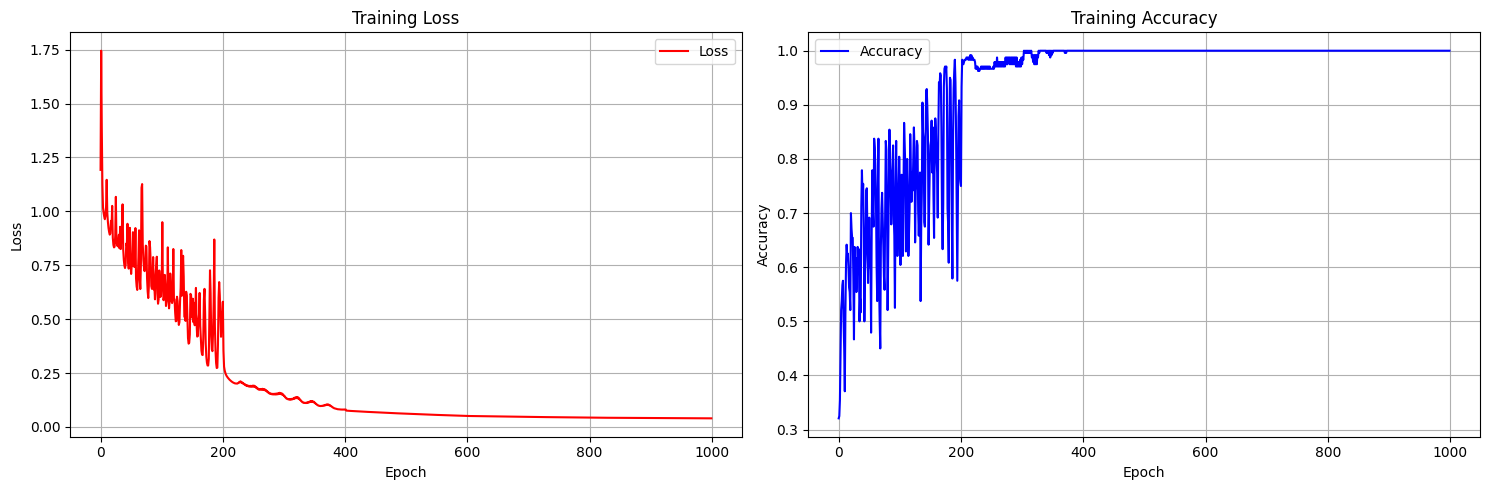

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(losses, label="Loss", color="red")
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot training accuracy
ax2.plot(accuracies, label="Accuracy", color="blue")
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Test accuracy

In [7]:
y_pred = nn.predict(X_test)
y_true = np.argmax(y_test, axis=1)

acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc:.3f}")


Test Accuracy: 0.517


Confusion Matrix

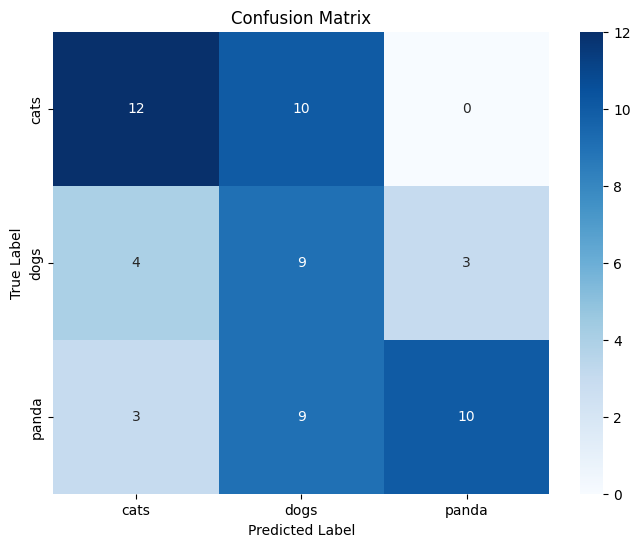

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dirs, yticklabels=dirs)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()